# Lab 5 — Image-to-Image Translation (Baseline CNN)

This notebook implements a simple Encoder–Decoder CNN for paired image translation using CIFAR-10.

Pipeline:
1. Load CIFAR10 dataset
2. Create paired images
3. Normalize images to [-1,1]
4. Train Encoder–Decoder CNN
5. Evaluate using L1/MSE loss
6. Visualize translated images


In [ ]:
!pip install tensorflow matplotlib


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models


In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


In [ ]:
# Convert RGB → Grayscale
def rgb_to_gray(images):
    gray = tf.image.rgb_to_grayscale(images)
    gray = tf.image.grayscale_to_rgb(gray)  # keep 3 channels
    return gray.numpy()

y_train = rgb_to_gray(x_train)
y_test = rgb_to_gray(x_test)

print("Input shape:", x_train.shape)
print("Target shape:", y_train.shape)


Input shape: (50000, 32, 32, 3)
Target shape: (50000, 32, 32, 3)


In [ ]:
def normalize(images):
    return (images.astype("float32") / 127.5) - 1

x_train = normalize(x_train)
y_train = normalize(y_train)
x_test = normalize(x_test)
y_test = normalize(y_test)

print("Range:", x_train.min(), x_train.max())


Range: -1.0 1.0


In [ ]:
def build_model():
    inputs = layers.Input(shape=(32,32,3))

    # Encoder
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,507 (5.03 MB)

 Trainable params: 1,317,507 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss="mae",   # L1 loss
    metrics=["mse"]
)


In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64
)


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.1783 - mse: 0.0681 - val_loss: 0.0794 - val_mse: 0.0128
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0727 - mse: 0.0109 - val_loss: 0.0589 - val_mse: 0.0072
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0569 - mse: 0.0067 - val_loss: 0.0498 - val_mse: 0.0052
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0485 - mse: 0.0049 - val_loss: 0.0446 - val_mse: 0.0041
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0434 - mse: 0.0039 - val_loss: 0.0400 - val_mse: 0.0034
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0397 - mse: 0.0033 - val_loss: 0.0369 - val_mse: 0.0029
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0369 - mse: 0.0028 - val_loss: 0.0352 - val_mse: 0.0026
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0345 - mse: 0.0025 - val_loss: 0.0324 - val_mse: 0.0022
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - 

In [ ]:
predictions = model.predict(x_test[:5])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


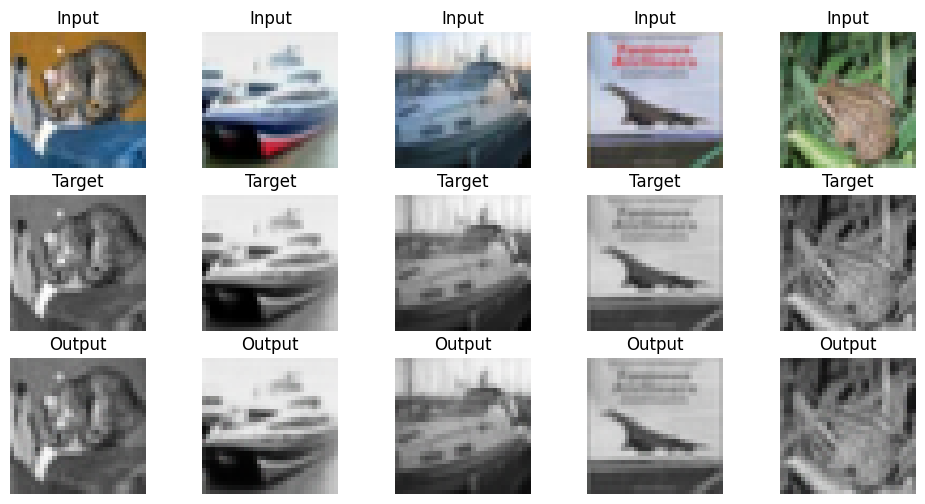

In [ ]:
def denormalize(img):
    return (img + 1) / 2

plt.figure(figsize=(12,6))

for i in range(5):
    # Input image
    plt.subplot(3,5,i+1)
    plt.imshow(denormalize(x_test[i]))
    plt.title("Input")
    plt.axis("off")

    # Target image
    plt.subplot(3,5,i+6)
    plt.imshow(denormalize(y_test[i]))
    plt.title("Target")
    plt.axis("off")

    # Predicted image
    plt.subplot(3,5,i+11)
    plt.imshow(denormalize(predictions[i]))
    plt.title("Output")
    plt.axis("off")

plt.show()


 ## Observations — Encoder–Decoder Output

The generated images appear blurry and lack sharp details.

Reason:
The model is trained only with reconstruction loss (L1/MSE).
This causes the network to learn average pixel values, producing smooth but blurry images.

This is a known limitation of baseline image-to-image translation without GANs.


 ## Why Are Outputs Blurry?

Loss functions used:
• L1 Loss (MAE)
• MSE Loss

These losses minimize pixel differences, encouraging the network to produce the average of all possible outputs.

Without an adversarial loss (GAN), the model cannot learn high-frequency details.


## Conclusion

In this lab we implemented a baseline CNN for image-to-image translation using CIFAR10.

Key Learnings:
• Encoder–Decoder CNN can learn image mapping
• Normalization to [-1,1] is important for training stability
• Reconstruction loss produces smooth but blurry outputs
• GANs are required for sharp realistic image translation

This baseline forms the foundation for Pix2Pix GAN models.
